# Ground State of the 1D Ising model — Extensions beyond the NetKet tutorial

This notebook extends the NetKet tutorial on the 1D TFIM  
[“Ground-state of the Ising model”](https://netket.readthedocs.io/en/latest/tutorials/gs-ising.html).

**New contributions (beyond the tutorial)**
1. **CNN ansatz (1D)** — local receptive fields for short-range correlations.
2. **Transformer (factored, translation-equivariant)** — distance-aware mixing for long-range structure.
3. **Autoregressive NQS (ARNN / masked CNN)** — **exact sampling** via factorized Born probabilities.

Baseline sections (**Mean-Field, Jastrow, FFN, Translation symmetry**) follow the tutorial and are used for comparison.

A companion notebook `ising_without_netket.ipynb` reimplements the key ideas **without** NetKet abstractions to expose the underlying VMC machinery.


### Build Hamiltonian (from tutorial)

In [1]:
import netket as nk

N = 12
hi = nk.hilbert.Spin(s=1 / 2, N=N)

print(hi)

Spin(s=1/2, N=12, ordering=new)


c:\Users\maxim\anaconda3\envs\nqs311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import jax

hi.random_state(jax.random.key(0), 3)  # give us 3 random states of 10 spins

Array([[-1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1, -1],
       [ 1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1],
       [-1,  1,  1,  1, -1, -1,  1,  1,  1, -1, -1,  1]], dtype=int8)

In [3]:
from netket.operator.spin import sigmax, sigmaz

# We build the Hamiltonian as a matrix (sparse) for exact diagonalization  

Gamma = -1
H = sum([Gamma * sigmax(hi, i) for i in range(N)])

V = -1
H += sum([V * sigmaz(hi, i) @ sigmaz(hi, (i + 1) % N) for i in range(N)])

## Exact diagonalization (from tutorial)

In [4]:
from scipy.sparse.linalg import eigsh

sp_h = H.to_sparse()
sp_h.shape

eig_vals, eig_vecs = eigsh(sp_h, k=2, which="SA")

print("eigenvalues with scipy sparse:", eig_vals)

E_gs = eig_vals[0]

eigenvalues with scipy sparse: [-15.32259515 -15.19150823]


## Mean-Field Ansatz (from tutorial)

In [5]:
# numerical operations in the model should always use jax.numpy
# instead of numpy because jax supports computing derivatives.
# If you want to better understand the difference between the two, check
# https://flax.readthedocs.io/en/latest/notebooks/jax_for_the_impatient.html
import jax.numpy as jnp

# Flax is a framework to define models using jax

# Flax has two 'neural network' libraries. THe  first one is `flax.linen`
# which has been in use since 2020, and most examples use it. The new one,
# nnx, is somewhat simpler to use, and it's the one we will use here.
from flax import nnx


# An NNX model must be a class subclassing `nnx.Module`
class MF(nnx.Module):
    """
    A class implementing a uniform mean-field model.
    """

    # The __init__ function is used to define the parameters of the model
    # The RNG argument is used to initialize the parameters of the model.
    def __init__(self, *, rngs: nnx.Rngs):
        # To generate random numbers we need to extract the key from the
        # `rngs` object.
        key = rngs.params()
        # We store the log-wavefunction on a single site, and we call it
        # `log_phi_local`. This is a variational parameter, and it will be
        # optimized during training.
        #
        # We store a single real parameter, as we assume the wavefunction
        # is normalised, and initialise it according to a normal distibution.
        self.log_phi_local = nnx.Param(jax.random.normal(key, (1,)))

    # The __call__(self, x) function should take as
    # input a batch of states x.shape = (n_samples, L)
    # and should return a vector of n_samples log-amplitudes
    def __call__(self, x: jax.Array):

        # compute the probabilities
        p = nnx.log_sigmoid(self.log_phi_local * x)

        # sum the output
        return 0.5 * jnp.sum(p, axis=-1)

In [6]:
# Create an instance of the model, using the seed 0
mf_model = MF(rngs=nnx.Rngs(0))
# If you want to learn more about how to use this model, check the nnx tutorial
# https://flax.readthedocs.io/en/latest/nnx_basics.html

# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

# Construct the variational state using the model and the sampler above.
# n_samples specifies how many samples should be used to compute expectation
# values.
vstate = nk.vqs.MCState(sampler, mf_model, n_samples=512)

print(vstate.parameters)

{'log_phi_local': Array([1.88002989], dtype=float64)}


In [7]:
E = vstate.expect(H)
print(E)

print("Mean                  :", E.mean)
print("Error                 :", E.error_of_mean)
print("Variance              :", E.variance)
print("Convergence indicator :", E.R_hat)
print("Correlation time      :", E.tau_corr)

-14.629 ± 0.083 [σ²=3.5e+00, R̂=1.034]
Mean                  : -14.629177692088163
Error                 : 0.08280628321798354
Variance              : 3.510722836672974
Convergence indicator : 1.0343179263671636
Correlation time      : 0.0


In [8]:
vstate.expect_and_grad(H)

(-14.629 ± 0.083 [σ²=3.5e+00, R̂=1.034],
 {'log_phi_local': Array([-0.99720794], dtype=float64)})

## Optimization loop (from tutorial)

Manual optimization

In [9]:
from tqdm import tqdm

energy_history = []
n_steps = 100

# For every iteration (tqdm is just a progress bar)
for i in tqdm(range(n_steps)):
    # compute energy and gradient of the energy
    E, E_grad = vstate.expect_and_grad(H)
    # log the energy to a list
    energy_history.append(E.mean.real)
    # equivalent to vstate.parameters - 0.05*E_grad , but it performs this
    # function on every leaf of the dictionaries containing the set of parameters
    new_pars = jax.tree_util.tree_map(
        lambda x, y: x - 0.05 * y, vstate.parameters, E_grad
    )
    # actually update the parameters
    vstate.parameters = new_pars

100%|██████████| 100/100 [00:01<00:00, 77.32it/s]


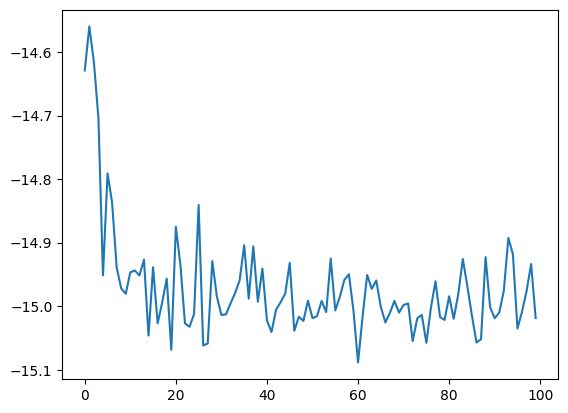

In [10]:
import matplotlib.pyplot as plt

plt.plot(energy_history)

NetKet optimization

In [11]:
# First we reset the parameters to run the optimisation again
vstate.init_parameters()

# Then we create an optimiser from the standard library.
# You can also use optax.
optimizer = nk.optimizer.Sgd(learning_rate=0.05)

# build the optimisation driver
gs = nk.driver.VMC(H, optimizer, variational_state=vstate)

# run the driver for 300 iterations. This will display a progress bar
# by default.
gs.run(n_iter=300)

mf_energy = vstate.expect(H)
error = abs((mf_energy.mean - E_gs) / E_gs)
print("Optimized energy and relative error: ", mf_energy, error)

100%|██████████| 300/300 [00:05<00:00, 57.46it/s, Energy=-14.989 ± 0.034 [σ²=6.1e-01, R̂=1.015]] 


Optimized energy and relative error:  -15.054 ± 0.041 [σ²=8.5e-01, R̂=1.034] 0.01752848149570578


## Jastrow Ansatz (from tutorial)

In [12]:
class JasShort(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):

        # Define two parameters j1, and j2.
        # Initialise them with a random normal distribution of standard deviation
        # 0.01
        # We must get a different key for each parameter, otherwise they will be
        # initialised with the same value.
        self.j1 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)
        self.j2 = nnx.Param(0.01 * jax.random.normal(rngs.params(), (1,)), dtype=float)

    def __call__(self, x: jax.Array):

        # compute the nearest-neighbor correlations
        corr1 = x * jnp.roll(x, -1, axis=-1)
        corr2 = x * jnp.roll(x, -2, axis=-1)

        # sum the output
        return jnp.sum(self.j1 * corr1 + self.j2 * corr2, axis=-1)


# Initialise the model wtih seed 1
model = JasShort(rngs=nnx.Rngs(1))

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

In [13]:
optimizer = nk.optimizer.Sgd(learning_rate=0.01)
gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

# construct the logger
log = nk.logging.RuntimeLog()

# One or more logger objects must be passed to the keyword argument `out`.
gs.run(n_iter=300, out=log)

print(
    f"Final optimized parameters: j1={vstate.parameters['j1']}, j2={vstate.parameters['j2']}"
)

jas_energy = vstate.expect(H)
error = abs((jas_energy.mean - E_gs) / E_gs)
print(f"Optimized energy : {jas_energy}")
print(f"relative error   : {error}")


100%|██████████| 300/300 [00:07<00:00, 38.89it/s, Energy=-15.270 ± 0.019 [σ²=3.5e-01, R̂=1.020]]


Final optimized parameters: j1=[0.2329507], j2=[0.09055762]
Optimized energy : -15.205 ± 0.018 [σ²=3.1e-01, R̂=1.008]
relative error   : 0.007702486385727556


In [14]:
data_jastrow = log.data
print(data_jastrow)

HistoryDict with 2 elements:
	'Energy' -> History(keys=['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], n_iters=300)
	'acceptance' -> History(keys=['value'], n_iters=300)


Text(0, 0.5, 'Energy')

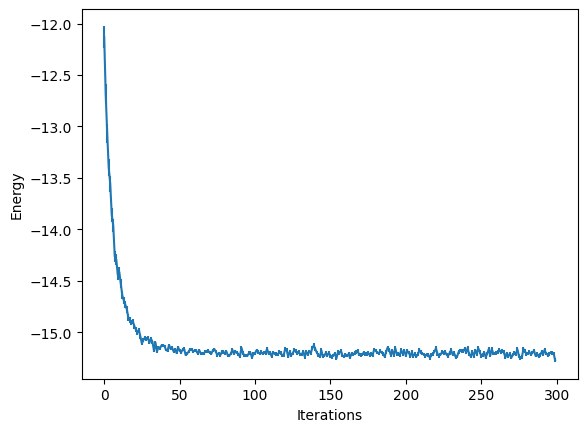

In [15]:
from matplotlib import pyplot as plt

plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
)
plt.xlabel("Iterations")
plt.ylabel("Energy")

### Neural-Network Quantum State (from tutorial)

In [16]:
from flax import nnx
import jax.numpy as jnp


# Create the local sampler on the hilbert space
sampler = nk.sampler.MetropolisLocal(hi)

class FFN(nnx.Module):

    def __init__(self, N: int, alpha: int = 1, *, rngs: nnx.Rngs):
        """
        Construct a Feed-Forward Neural Network with a single hidden layer.

        Args:
            N: The number of input nodes (number of spins in the chain).
            alpha: The density of the hidden layer. The hidden layer will have
                N*alpha nodes.
            rngs: The random number generator seed.
        """
        self.alpha = alpha

        # We define a linear (or dense) layer with `alpha` times the number of input nodes
        # as output nodes.
        # We must pass forward the rngs object to the dense layer.
        self.linear = nnx.Linear(in_features=N, out_features=alpha * N, rngs=rngs)

    def __call__(self, x: jax.Array):

        # we apply the linear layer to the input
        y = self.linear(x)

        # the non-linearity is a simple ReLu
        y = nnx.relu(y)

        # sum the output
        return jnp.sum(y, axis=-1)


model = FFN(N=N, alpha=1, rngs=nnx.Rngs(2))

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

In [17]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log)

ffn_energy = vstate.expect(H)
error = abs((ffn_energy.mean - E_gs) / E_gs)
print("Optimized energy and relative error: ", ffn_energy, error)

100%|██████████| 300/300 [00:13<00:00, 22.59it/s, Energy=-15.3140 ± 0.0064 [σ²=4.2e-02, R̂=1.004]]


Optimized energy and relative error:  -15.3189 ± 0.0070 [σ²=5.0e-02, R̂=1.005] 0.0002392600170201101


Text(0, 0.5, 'Energy')

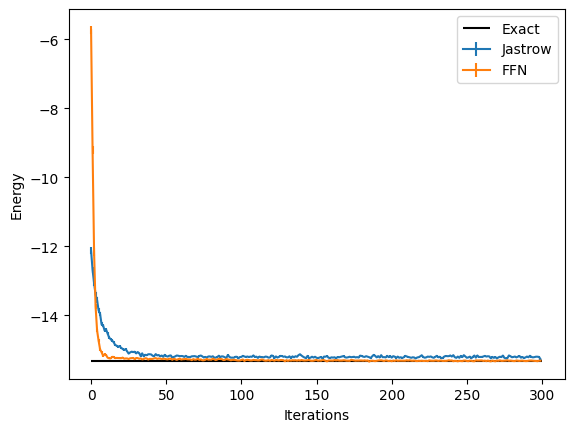

In [18]:
data_FFN = log.data

plt.errorbar(
    data_jastrow["Energy"].iters,
    data_jastrow["Energy"].Mean,
    yerr=data_jastrow["Energy"].Sigma,
    label="Jastrow",
)
plt.errorbar(
    data_FFN["Energy"].iters,
    data_FFN["Energy"].Mean,
    yerr=data_FFN["Energy"].Sigma,
    label="FFN",
)
plt.hlines([E_gs], xmin=0, xmax=300, color="black", label="Exact")
plt.legend()

plt.xlabel("Iterations")
plt.ylabel("Energy")

## Translation Symmetry (from tutorial)

In [19]:
graph = nk.graph.Chain(length=N, pbc=True)

print(graph.translation_group())

TranslationGroup(lattice:
Lattice(
    n_nodes=12,
    extent=[12],
    basis_vectors=
        [[1.]],
    site_offsets=
        [[0.]],
)

axes:(0,))


In [20]:
Gamma = -1
H = sum([Gamma * sigmax(hi, i) for i in range(N)])

V = -1
H += sum([V * sigmaz(hi, i) @ sigmaz(hi, j) for (i, j) in graph.edges()])

In [21]:
import flax.linen as nn
import netket.nn as nknn


class SymmModel(nnx.Module):

    def __init__(self, N: int, alpha: int = 1, *, rngs: nnx.Rngs):
        """
        Construct a Feed-Forward Neural Network with a single hidden layer.

        Args:
            N: The number of input nodes (number of spins in the chain).
            alpha: The density of the hidden layer. The hidden layer will have
                N*alpha nodes.
            rngs: The random number generator seed.
        """
        self.alpha = alpha

        # We want to use netket's DenseSymm layer, which requires a symmetry group.
        dense_symm_linen = nknn.DenseSymm(
            symmetries=graph.translation_group(),
            features=alpha,
            kernel_init=nn.initializers.normal(stddev=0.01),
        )
        # However, this layer is defined using ``flax.linen``, so to use it with NNX we
        # must resort to the conversion function ``nnx.bridge.ToNNX``.
        # The syntax is a bit weird, as we need to separately pass the random number generator
        # and then initialize the layer with a dummy input of shape (1, 1, Nsites).
        self.linear_symm = nnx.bridge.ToNNX(dense_symm_linen, rngs=rngs).lazy_init(
            jnp.ones((1, 1, N))
        )

    def __call__(self, x: jax.Array):
        # add an extra dimension with size 1, because DenseSymm requires rank-3 tensors as inputs.
        # the shape will now be (batches, 1, Nsites)
        x = x.reshape(-1, 1, x.shape[-1])

        x = self.linear_symm(x)
        x = nnx.relu(x)

        # sum the output
        return jnp.sum(x, axis=(-1, -2))


sampler = nk.sampler.MetropolisLocal(hi)

# Let us define a model with 4 features per symmetry
model = SymmModel(N=N, alpha=4, rngs=nnx.Rngs(2))

vstate = nk.vqs.MCState(sampler, model, n_samples=1008)

vstate.n_parameters

52

In [22]:
optimizer = nk.optimizer.Sgd(learning_rate=0.1)

gs = nk.driver.VMC(
    H,
    optimizer,
    variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log)

symm_energy = vstate.expect(H)
error = abs((symm_energy.mean - E_gs) / E_gs)
print("Optimized energy and relative error: ", symm_energy, error)

100%|██████████| 300/300 [00:13<00:00, 22.37it/s, Energy=-15.3218 ± 0.0013 [σ²=1.6e-03, R̂=1.002]]


Optimized energy and relative error:  -15.3211 ± 0.0012 [σ²=1.5e-03, R̂=1.009] 0.00010028827245362886


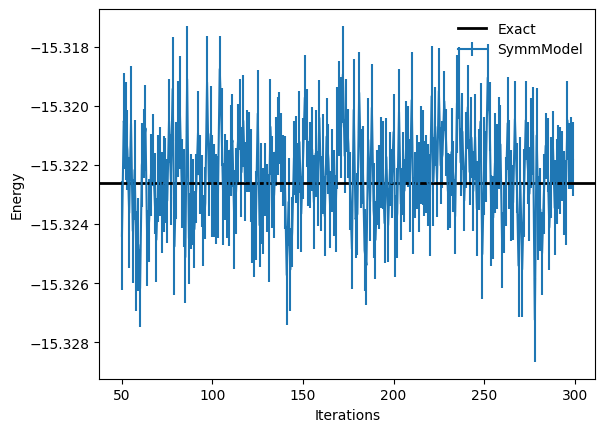

In [23]:
plt.errorbar(
    log.data["Energy"].iters[50:],
    log.data["Energy"].Mean[50:],
    yerr=log.data["Energy"].Sigma[50:],
    label="SymmModel",
)

plt.axhline(
    y=E_gs,
    xmin=0,
    xmax=log.data["Energy"].iters[-1],
    linewidth=2,
    color="k",
    label="Exact",
)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.legend(frameon=False)

# New content


## Convolutional Neural Network Ansatz (new)

**Why a CNN?** TFIM correlations are predominantly local; 1D convolutions give an inductive bias toward short-range structure and translation invariance (after pooling).

The network outputs a real scalar per configuration interpreted as $\log|\psi(x)|$. (No complex phase here; TFIM is stoquastic in the $\sigma^z$ basis ⇒ a positive gauge exists, so a modulus-only model is consistent.)

**Design.**
- 1D conv stem + residual **CNNBlock** (LayerNorm + GELU).
- Global mean pooling over sites → translation-invariant representation.
- A final dense head outputs $\log|\psi|$.

**Training.** Standard NetKet VMC + SR; Metropolis–Hastings sampling (`MetropolisLocal`).


In [24]:
# --- Basic Conv Block ---
class CNNBlock(nn.Module):
    features: int
    kernel_size: int
    use_residual: bool = True

    @nn.compact
    def __call__(self, x):
        # Normalization
        y = nn.LayerNorm(dtype=jnp.float32)(x)
        y = nn.Conv(self.features, kernel_size=(self.kernel_size,), padding="SAME")(y)
        y = nn.gelu(y)
        y = nn.Conv(self.features, kernel_size=(self.kernel_size,), padding="SAME")(y)

        if self.use_residual and x.shape[-1] == self.features:
            y = x + y
        return y


# --- Core CNN architecture ---
class CNNCore(nn.Module):
    N: int
    channels: int = 32
    depth: int = 3
    kernel_size: int = 5

    @nn.compact
    def __call__(self, spins):       # spins: (B,N)
        x = spins.astype(jnp.float32)[..., None]   # (B,N,1)
        x = nn.Conv(self.channels, kernel_size=(self.kernel_size,), padding="SAME")(x)
        x = nn.gelu(x)

        # Stack several convolutional blocks
        for _ in range(self.depth - 1):
            x = CNNBlock(self.channels, self.kernel_size)(x)

        # Pool and output
        pooled = jnp.mean(x, axis=1)                       # (B,channels)
        log_amp = nn.Dense(1, dtype=jnp.float32)(pooled)[..., 0]
        return log_amp


# --- NNX wrapper for NetKet ---
class CNNLogPsi(nnx.Module):
    def __init__(self, N: int, *, rngs: nnx.Rngs, channels=32, depth=3, kernel_size=5):
        self.core = nnx.bridge.ToNNX(
            CNNCore(N=N, channels=channels, depth=depth, kernel_size=kernel_size),
            rngs=rngs
        ).lazy_init(jnp.ones((1, N), dtype=jnp.float32))

    def __call__(self, x):
        return self.core(x)


In [25]:
sampler = nk.sampler.MetropolisLocal(hi)

cnn_model = CNNLogPsi(
    N=N, rngs=nnx.Rngs(123),
    channels=32, depth=3, kernel_size=5
)

vstate = nk.vqs.MCState(
    sampler, cnn_model,
    n_samples=512,           
    n_discard_per_chain=16,
    chunk_size=256
)


opt = nk.optimizer.Sgd(learning_rate=0.05)
driver = nk.driver.VMC(
    H, opt, variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1),
)

log = nk.logging.RuntimeLog()
driver.run(n_iter=100, out=log)

cnn_energy = vstate.expect(H)
rel_err = abs((cnn_energy.mean - E_gs)/E_gs)
print("CNN energy:", cnn_energy)
print("Relative error:", rel_err)

100%|██████████| 100/100 [02:14<00:00,  1.35s/it, Energy=-15.289 ± 0.014 [σ²=1.0e-01, R̂=1.021]]


CNN energy: -15.325 ± 0.013 [σ²=8.1e-02, R̂=1.012]
Relative error: 0.00012619301509095225


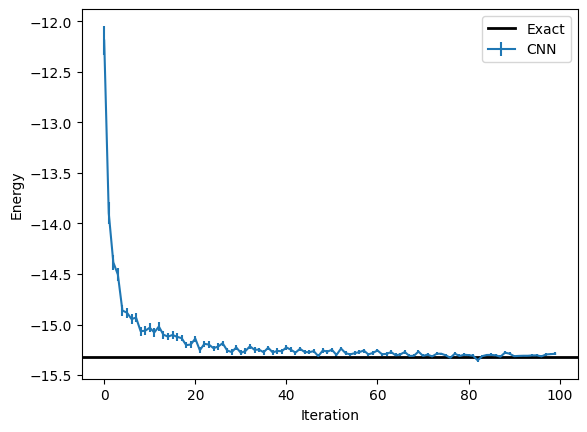

In [26]:
plt.errorbar(
    log.data["Energy"].iters,
    log.data["Energy"].Mean.real,
    yerr=log.data["Energy"].Sigma,
    label="CNN"
)

plt.axhline(E_gs, linewidth=2, color="black", label="Exact")
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.legend(); plt.show()

## Transformer Ansatz with Factored Attention (new)

Inspired from the tutorial on Vision Transformer Wavefunction

**Objective**  
Capture long-range correlations and entanglement patterns through a Transformer.

**Design choices**  
- No absolute positional embeddings; only relative distances are learned → translation equivariance.  
- Factored self-attention as suggested in the tutorial
- Residual feed-forward blocks refine features after attention.  
- Mean pooling over sites yields a scalar $\log|\psi(x)|$.

In [27]:
from einops import rearrange

# Embedding (1D) (no positional encoding)
class Embed(nn.Module):
    d_model: int
    param_dtype = jnp.float64

    def setup(self):
        self.proj = nn.Dense(
            self.d_model,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=self.param_dtype,
        )

    def __call__(self, spins):
        """
        spins: (B, N) in {-1, +1}
        returns: (B, N, d_model)
        """
        x = jnp.atleast_2d(spins).astype(self.param_dtype)[..., None]  # (B, N, 1)
        x = self.proj(x)                                              # (B, N, d)
        return x


# Factored Multi-Head Attention (position-only, circulant 1D)
class FMHA(nn.Module):
    d_model: int
    n_heads: int
    n_tokens: int            # sequence length N
    param_dtype = jnp.float64

    def setup(self):
        assert self.d_model % self.n_heads == 0, "d_model must be divisible by n_heads"
        self.v_proj = nn.Dense(
            self.d_model,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=self.param_dtype,
        )
        self.out_proj = nn.Dense(
            self.d_model,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=self.param_dtype,
        )
        # Per-head distance kernels: alpha[h, delta], delta in [0..N-1]
        self.alpha = self.param(
            "alpha",
            nn.initializers.xavier_uniform(),
            (self.n_heads, self.n_tokens),
            self.param_dtype,
        )

    def __call__(self, x):
        """
        x: (B, N, d_model)
        returns: (B, N, d_model)
        """
        B, N, D = x.shape
        H = self.n_heads
        d_h = D // H

        # Values projection and head split
        V = self.v_proj(x)                                     # (B, N, D)
        V = rearrange(V, "b n (h d) -> b h n d", h=H)          # (B, H, N, d_h)

        # Build circulant mixing matrices A[h, i, j] = alpha[h, (i-j) mod N]
        idx  = jnp.arange(N)
        dist = (idx[None, :] - idx[:, None]) % N               # (N, N)
        A    = self.alpha[:, dist]                             # (H, N, N)

        # Position-only mixing per head
        Y = jnp.einsum("hij, bhjd -> bhid", A, V)              # (B, H, N, d_h)

        # Merge heads and output projection
        Y = rearrange(Y, "b h n d -> b n (h d)")               # (B, N, D)
        Y = self.out_proj(Y)                                   # (B, N, D)
        return Y


# Encoder Block (1D)
class EncoderBlock(nn.Module):
    d_model: int
    n_heads: int
    n_tokens: int
    param_dtype = jnp.float64

    def setup(self):
        self.ln1 = nn.LayerNorm(param_dtype=self.param_dtype)
        self.attn = FMHA(
            d_model=self.d_model,
            n_heads=self.n_heads,
            n_tokens=self.n_tokens,
        )
        self.ln2 = nn.LayerNorm(param_dtype=self.param_dtype)
        self.ff = nn.Sequential(
            [
                nn.Dense(
                    2 * self.d_model,
                    kernel_init=nn.initializers.xavier_uniform(),
                    param_dtype=self.param_dtype,
                ),
                nn.gelu,
                nn.Dense(
                    self.d_model,
                    kernel_init=nn.initializers.xavier_uniform(),
                    param_dtype=self.param_dtype,
                ),
            ]
        )

    def __call__(self, x):
        # Pre-norm + factored attention + residual
        y = self.ln1(x)
        y = self.attn(y)
        x = x + y

        # Pre-norm + feed-forward + residual
        y = self.ln2(x)
        y = self.ff(y)
        x = x + y
        return x


# Encoder (1D)
class Encoder(nn.Module):
    depth: int
    d_model: int
    n_heads: int
    n_tokens: int

    def setup(self):
        self.layers = [
            EncoderBlock(
                d_model=self.d_model,
                n_heads=self.n_heads,
                n_tokens=self.n_tokens,
            )
            for _ in range(self.depth)
        ]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# Output Head (1D)
class OutputHead(nn.Module):
    d_model: int
    param_dtype = jnp.float64

    def setup(self):
        self.out_ln = nn.LayerNorm(param_dtype=self.param_dtype)
        self.out = nn.Dense(
            1,
            kernel_init=nn.initializers.xavier_uniform(),
            param_dtype=self.param_dtype,
        )

    def __call__(self, x):
        """
        x: (B, N, d_model)
        returns: (B,)  -> real log|psi|
        """
        # Mean over sites -> translation-invariant representation
        pooled = jnp.mean(x, axis=1)               # (B, d_model)
        z = self.out_ln(pooled)
        log_amp = self.out(z)[..., 0]              # (B,)
        return log_amp


# Full 1D Transformer model
class Transformer1D(nn.Module):
    depth: int
    d_model: int
    n_heads: int
    n_tokens: int

    @nn.compact
    def __call__(self, spins):
        """
        spins: (B, N)
        returns: (B,) real log|psi|
        """
        x = Embed(d_model=self.d_model)(spins)                 # (B, N, d)
        x = Encoder(
            depth=self.depth,
            d_model=self.d_model,
            n_heads=self.n_heads,
            n_tokens=self.n_tokens,
        )(x)                                                   # (B, N, d)
        log_psi = OutputHead(d_model=self.d_model)(x)          # (B,)
        return log_psi


# NetKet wrapper (NNX) 
class TransformerLogPsi(nnx.Module):
    def __init__(self, N: int, *, rngs: nnx.Rngs, d_model=32, depth=2, n_heads=2):
        self.core = nnx.bridge.ToNNX(
            Transformer1D(
                depth=depth,
                d_model=d_model,
                n_heads=n_heads,
                n_tokens=N,
            ),
            rngs=rngs,
        ).lazy_init(jnp.ones((1, N), dtype=jnp.float64))

    def __call__(self, x):
        return self.core(x)

In [28]:
sampler = nk.sampler.MetropolisLocal(hi)

model = TransformerLogPsi(
    N=N, rngs=nnx.Rngs(42),
    d_model=32, depth=2, n_heads=2  
)

vstate = nk.vqs.MCState(
    sampler, model,
    n_samples=512,           
    n_discard_per_chain=8,
    chunk_size=256
)

In [29]:
opt = nk.optimizer.Sgd(learning_rate=0.05)

log = nk.logging.RuntimeLog()
driver = nk.driver.VMC(
    H, opt, variational_state=vstate,
    preconditioner=nk.optimizer.SR(diag_shift=0.1) 
)

driver.run(n_iter=100, out=log)

print(vstate.expect(H))

100%|██████████| 100/100 [03:08<00:00,  1.89s/it, Energy=-15.3264 ± 0.0055 [σ²=1.6e-02, R̂=1.018]]


-15.3233 ± 0.0041 [σ²=8.8e-03, R̂=1.008]


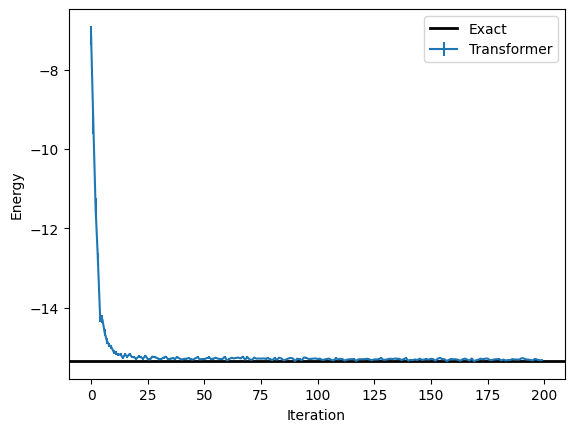

Transformer energy: -15.293 ± 0.017 [σ²=1.2e-01]
Relative error: 0.0019556957950675954


In [37]:
plt.errorbar(
    log.data["Energy"].iters,
    log.data["Energy"].Mean.real,
    yerr=log.data["Energy"].Sigma,
    label="Transformer"
)
plt.axhline(E_gs, color="black", linewidth=2, label="Exact")
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.legend(); plt.show()

E_tr = vstate.expect(H)
rel_err = abs((E_tr.mean - E_gs)/E_gs)
print("Transformer energy:", E_tr)
print("Relative error:", rel_err)

## Autoregressive models (ARNN & masked CNN) — new

**Goal**  
Learn a fully normalized wavefunction to enable **exact sampling** (no burn-in, no autocorrelation) and faster, more stable VMC.

**Models used**
- **ARNN (Dense):** `nk.models.ARNNDense` — autoregressive MLP producing conditionals $ \psi_i(s_i\mid s_{<i}) $.
- **Masked CNN (fast AR conv):** `nk.models.FastARNNConv1D` — **masked 1D convolutions** that preserve the autoregressive factorization while expanding the receptive field efficiently.

**Sampler**  
Both models pair with `nk.sampler.ARDirectSampler`, which draws **independent** samples from the learned conditionals.


**Protocol**  
Initialize model → `ARDirectSampler` → `MCState` → optimize with VMC + SR → report energy and relative error vs $E_{\mathrm{gs}}$.


### ARNN

In [31]:
model = nk.models.ARNNDense(hilbert=hi, layers=3, features=10)

# the autoregressive model has an exact sampler because of the conditional prob
sampler = nk.sampler.ARDirectSampler(hi)

# With direct sampling, we don't need many samples in each step to form a
# Markov chain, and we don't need to discard samples
vstate = nk.vqs.MCState(sampler, model, n_samples=512)

print(f"Number of parameters (ARNNDense): {vstate.n_parameters}")

Number of parameters (ARNNDense): 18984


In [32]:
optimizer = nk.optimizer.Sgd(learning_rate=0.02)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

# Notice the use, again of Stochastic Reconfiguration, which considerably improves the optimisation
gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

# logging and running
log = nk.logging.RuntimeLog()
gs.run(n_iter=300, out=log)

arnn_energy = vstate.expect(H)
error = abs((arnn_energy.mean - E_gs) / E_gs)
print(f"Optimized energy: {arnn_energy} \nRelative error: {error*100:.2f}%")

100%|██████████| 300/300 [01:51<00:00,  2.68it/s, Energy=-15.322 ± 0.014 [σ²=8.0e-02]]


Optimized energy: -15.304 ± 0.013 [σ²=1.2e-01] 
Relative error: 0.12%


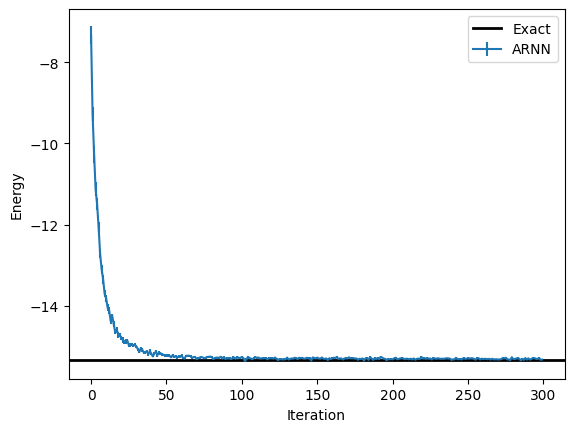

In [33]:
plt.errorbar(
    log.data["Energy"].iters,
    log.data["Energy"].Mean.real,
    yerr=log.data["Energy"].Sigma,
    label="ARNN"
)
plt.axhline(E_gs, color="black", linewidth=2, label="Exact")
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.legend(); plt.show()

### Masked CNN

In [34]:
# Fast autoregressive 1D Conv model 
model = nk.models.FastARNNConv1D(hilbert=hi, layers=3, features=10, kernel_size=5)

sampler = nk.sampler.ARDirectSampler(hi)

vstate = nk.vqs.MCState(sampler, model, n_samples=512)
print(f"Number of parameters (FastARNNConv1D): {vstate.n_parameters}")


Number of parameters (FastARNNConv1D): 662


In [35]:
optimizer = nk.optimizer.Sgd(learning_rate=0.02)
preconditioner = nk.optimizer.SR(diag_shift=0.1)

gs = nk.driver.VMC(
    H, optimizer, variational_state=vstate, preconditioner=preconditioner
)

# logging and running
log = nk.logging.RuntimeLog()
gs.run(n_iter=200, out=log)

arnnconv_energy = vstate.expect(H)
error = abs((arnnconv_energy.mean - E_gs) / E_gs)
print(f"Optimized energy: {arnn_energy} \nRelative error: {error*100:.2f}%")

100%|██████████| 200/200 [01:43<00:00,  1.93it/s, Energy=-15.312 ± 0.014 [σ²=1.2e-01]]


Optimized energy: -15.304 ± 0.013 [σ²=1.2e-01] 
Relative error: 0.20%


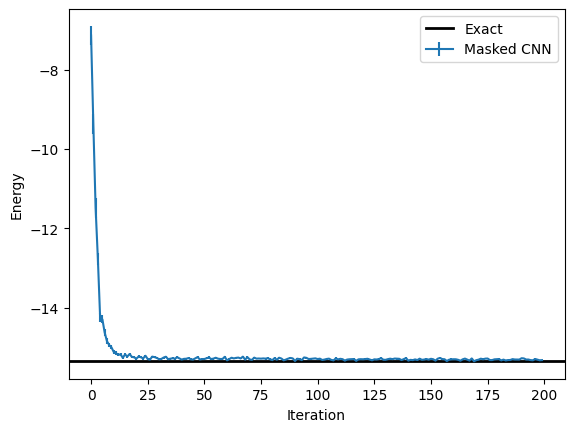

In [36]:
plt.errorbar(
    log.data["Energy"].iters,
    log.data["Energy"].Mean.real,
    yerr=log.data["Energy"].Sigma,
    label="Masked CNN"
)
plt.axhline(E_gs, color="black", linewidth=2, label="Exact")
plt.xlabel("Iteration"); plt.ylabel("Energy"); plt.legend(); plt.show()

---
### References
- G. Carleo & M. Troyer, “Solving the quantum many-body problem with artificial neural networks,”(2017).
- O. Sharir, Y. Levine, N. Wies, G. Carleo, A. Shashua, “Deep Autoregressive Models for the Efficient Variational Simulation of Many-Body Quantum Systems,” (2020).
- NetKet documentation: tutorials on TFIM, NQS, AR models.
